# GPT(Generative Pre-Training) Implementation

---
### **Description**

- Model Architecture:
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FCN9jO%2FbtsmiDJHWRI%2Fy9vSNfNEWCIsGzebxHBXPK%2Fimg.png"> </img> <br>

     Figure1. GPT Architecture and brief description of 4 different tasks(Radford, A. et. al, 2018)
<br>

- Dataset:
    - Paper : WikiQA: A Challenge Dataset for Open-Domain Question Answering
    <br>

- System Environment:
    - Goolge Colab Pro Plus GPU: A100


---

### **Reference**

[1] "GPT(Generative Pre-Training) Implementation", cchyun, accessed 2023 04 11, https://paul-hyun.github.io/gpt-01/.

[2] "[Paper Review] GPT : Generative Pre-training / OpenAI NLP", 구름위의공룡, accessed 2023 05 22, https://mr-waguwagu.tistory.com/27.

[3] "GPT1 Paper review Improving Language Understanding
by Generative Pre-Training", 이수진의블로그, accessed 2023 05 22, https://lsjsj92.tistory.com/617.

[3] Radford, A., Narasimhan, K., Salimans, T., & Sutskever, I. (2018). Improving language understanding by generative pre-training.

[4] Yang, Y., Yih, W. T., & Meek, C. (2015, September). Wikiqa: A challenge dataset for open-domain question answering. In Proceedings of the 2015 conference on empirical methods in natural language processing (pp. 2013-2018).


### Install Library

In [24]:
# install Sentencepiece library
pip install sentencepiece

### Load Library

In [68]:
# Sentencepiece
import sentencepiece as spm

# Torch
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Tools
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from tqdm import tqdm, tqdm_notebook, trange
from random import random, randrange, randint, shuffle, choice

In [26]:
# For Colab Environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Tokenization make a vocab using WikiQA dataset

corpus = "/content/drive/MyDrive/WikiQA.txt"
prefix = "WikiQA"
vocab_size = 12000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # Max length of sentence
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # User defined token

In [29]:
# Using Vocab test sentence into pieces

vocab_file = "WikiQA.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
  'i love soccer, and pizza'
]
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    a = vocab.Decode(ids)
    print(line)
    print(pieces)
    print(ids)
    print(a)
    print()

i love soccer, and pizza
['▁i', '▁love', '▁soc', 'cer', ',', '▁and', '▁p', 'iz', 'za']
[537, 3893, 4667, 1246, 11969, 42, 31, 229, 7489]
i love soccer, and pizza



### Set Configuration
- "n_dec_vocab": length of vocab
- "n_dec_seq": 256,
- "n_layer": 12,
- "d_hidn": 768,
- "i_pad": 0,
- "d_ff": 1024,
- "n_head": 16,
- "d_head": 48,
- "dropout": 0.1,
- "layer_norm_epsilon": 1e-12

In [32]:
# Define Configuration
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [33]:
# Set Configuration
config = Config({
    "n_dec_vocab": len(vocab),
    "n_dec_seq": 256,
    "n_layer": 12,
    "d_hidn": 768,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 16,
    "d_head": 48,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_dec_vocab': 12007, 'n_dec_seq': 256, 'n_layer': 12, 'd_hidn': 768, 'i_pad': 0, 'd_ff': 1024, 'n_head': 16, 'd_head': 48, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


### Define Sinusoidal Positional Encoding
- Sinusoidal encoding table
- attention pad mask
- attention decoder mask
- scale dot product attention
- multihead attention
- feed forward
- decoder layer
- decoder

In [34]:
# Sinusoidal Positional Encoding
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  #
    return pad_attn_mask


""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)

    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob


""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob


""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output


In [35]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, dec_inputs, self_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(self_att_outputs)
        ffn_outputs = self.layer_norm3(self_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob

In [10]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])

    def forward(self, dec_inputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)

        self_attn_probs = []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq)
            dec_outputs, self_attn_prob = layer(dec_outputs, dec_self_attn_mask)
            self_attn_probs.append(self_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)]
        return dec_outputs, self_attn_probs

### GPT
- Define GPT, GPT pretrain
- Create pretrain data per doc, pretrain data
- Make a pretrain data as json file

In [36]:
""" gpt """
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.decoder = Decoder(self.config)

    def forward(self, dec_inputs):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.decoder(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return dec_outputs, dec_self_attn_probs

    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)

    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

In [12]:
""" GPT pretrain """
class GPTPretrain(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.gpt = GPT(self.config)
        # lm
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_dec_vocab, bias=False)
        self.projection_lm.weight = self.gpt.decoder.dec_emb.weight

    def forward(self, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.gpt(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab)
        logits_lm = self.projection_lm(dec_outputs)
        # (bs, n_dec_seq - 1, n_dec_vocab), (bs, n_output), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return logits_lm, dec_self_attn_probs

In [37]:
""" create pretrain data per doc """
def create_pretrain_instances(doc, n_seq):
    # for [BOS], [EOS]
    max_seq = n_seq - 2
    tgt_seq = max_seq
    instances = []
    a_end=0
    for i in range(len(doc)):
        if doc[i] =='▁,':
            a_end = i

    tokens_a =["[BOS]"] + doc[:a_end] + ["[EOS]"]
    tokens_b = ["[BOS]"] + doc[a_end+1: ] + ["[EOS]"]
    # if len(tokens_a)>len(tokens_b):
    #     a= [0] * (len(tokens_a)-len(tokens_b))
    # else:
    #     a= [0] * (len(tokens_b)-len(tokens_a))
    # for i in range(len(doc)):
    #     tokens.append(doc[i]) # line

    instance = {
        "tokens_a": tokens_a,
        "tokens_b":tokens_b
    }
    instances.append(instance)
    return instances

In [38]:
""" Create pretrain data  """
def make_pretrain_data(vocab, in_file, out_file, n_seq):
    line_cnt = 0
    with open(in_file, "r", encoding='UTF8') as in_f:
        for line in in_f:
            line_cnt += 1

    docs = []
    with open(in_file, "r", encoding='UTF8') as f:
        doc = []
        with tqdm(total=line_cnt, desc=f"Loading") as pbar:
            for i, line in enumerate(f):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        docs.append(doc)
                        doc = []
                        # In order to reduce size of the memory only used 100k
                        if 100000 < len(docs): break
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
                pbar.update(1)
        if doc:
            docs.append(doc)
    docs = sum(docs,[])
    with open(out_file, "w", encoding='UTF8') as out_f:
        with tqdm(total=len(docs), desc=f"Making") as pbar:
            for i, doc in enumerate(docs):
                instances = create_pretrain_instances(doc, n_seq)
                for instance in instances:
                    print(instance, file=out_f)
                        # out_f.write(instance)
                        # out_f.write("\n")
                    pbar.update(1)


In [39]:
# make pretrain data as json file
in_file = "/content/drive/MyDrive/WikiQA.txt"
out_file = "WikiQA.json"

n_seq = 256
make_pretrain_data(vocab, in_file, out_file, n_seq)


Making: 100%|██████████| 63282/63282 [00:00<00:00, 89025.96it/s]


### Pretrain dataset
- Define pretrain dataset, pretrain data collate function
- Create pretrain dataloader

In [40]:
""" pretrain datatset """
class PretrainDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.sentences = []
        self.label = []
        line_cnt = 0
        with open(infile, "r", encoding='UTF8') as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r", encoding='UTF8') as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):

                line = json.dumps(line)
                instance = eval(json.loads(line))
                tokens_a = [vocab.piece_to_id(p) for p in instance["tokens_a"]]
                tokens_b = [vocab.piece_to_id(p) for p in instance["tokens_b"]]
                if len(tokens_a) > len(tokens_b):
                    a = [0]*(len(tokens_a) - len(tokens_b))
                    tokens_b = tokens_b +a

                else:
                    a = [0]*(len(tokens_b) - len(tokens_a))
                    tokens_a = tokens_a +a
                self.sentences.append(tokens_a)
                self.label.append(tokens_b)


    def __len__(self):
        assert len(self.sentences) == len(self.label)
        return len(self.sentences)

    def __getitem__(self, item):
        return (torch.tensor(self.sentences[item]),
                torch.tensor(self.label[item]),
                torch.tensor(item))

In [17]:
""" pretrain data collate_fn """
def pretrin_collate_fn(inputs):
    dec_inputs,labels,item = list(zip(*inputs))
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    batch = [
        dec_inputs,
        labels,
        torch.stack(item, dim=0)
    ]

    return batch

In [41]:
""" pretrain dataloader """
batch_size = 64
dataset = PretrainDataSet(vocab, "WikiQA.json")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True , collate_fn=pretrin_collate_fn)

Loading WikiQA.json: 100%|██████████| 63282/63282 [00:07<00:00, 8339.79 lines/s]


### Model training
- Define training steps per epoch
- Set device and Hyperparameter
- Train GPT Model

In [42]:
""" Train model per epoch """
def train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader):
    losses = []
    model.train()

    # with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
    for i, value in enumerate(train_loader):
        dec_inputs,labels_lm,_ = map(lambda v: v.to(config.device), value)

        optimizer.zero_grad()
        outputs = model(dec_inputs)

        logits_lm = outputs[0]
        # print(logits_lm.shape)
        loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(2)), labels_lm.view(-1))

        losses.append(loss_lm.cpu().detach().numpy())

        loss_lm.backward()
        optimizer.step()

    print(f"Loss: {loss_lm:.3f} , Perplexity: {np.exp(loss_lm.item())}")
            # pbar.update(1)
            # pbar.set_postfix_str(f"Loss: {loss_lm:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [43]:
# set device and hyperparameters

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(config)

learning_rate = 5e-5
betas=(0.9, 0.999)
weight_decay = 0.01
n_epoch = 20

{'n_dec_vocab': 12007, 'n_dec_seq': 256, 'n_layer': 12, 'd_hidn': 768, 'i_pad': 0, 'd_ff': 1024, 'n_head': 16, 'd_head': 48, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda')}


In [44]:
# Train GPT Model
model = GPTPretrain(config)
# save_pretrain = "save_gpt_pretrain_gpt.pth"
best_epoch, best_loss = 0, 0
# if os.path.isfile(save_pretrain):
#     best_epoch, best_loss = model.gpt.load(save_pretrain)
#     print(f"load pretrain from: {save_pretrain}, epoch={best_epoch}, loss={best_loss}")
#     best_epoch += 1

model.to(config.device)

criterion_lm = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
offset = best_epoch
for step in trange(n_epoch):
    epoch = step + offset
    loss = train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader)
    losses.append(loss)
    # model.gpt.save(epoch, loss, save_pretrain)

  5%|▌         | 1/20 [02:12<42:03, 132.80s/it]

Loss: 7.561 , Perplexity: 1921.7230009946895


 10%|█         | 2/20 [04:25<39:52, 132.91s/it]

Loss: 7.270 , Perplexity: 1437.086196008035


 15%|█▌        | 3/20 [06:38<37:37, 132.82s/it]

Loss: 4.217 , Perplexity: 67.84156138153749


 20%|██        | 4/20 [08:51<35:25, 132.83s/it]

Loss: 4.097 , Perplexity: 60.17148002546026


 25%|██▌       | 5/20 [11:04<33:13, 132.89s/it]

Loss: 5.562 , Perplexity: 260.3810634876626


 30%|███       | 6/20 [13:17<30:59, 132.83s/it]

Loss: 5.046 , Perplexity: 155.34153794991076


 35%|███▌      | 7/20 [15:29<28:46, 132.77s/it]

Loss: 5.893 , Perplexity: 362.38246792656236


 40%|████      | 8/20 [17:42<26:34, 132.86s/it]

Loss: 4.553 , Perplexity: 94.91070991167621


 45%|████▌     | 9/20 [19:54<24:18, 132.55s/it]

Loss: 3.816 , Perplexity: 45.44164156565117


 50%|█████     | 10/20 [22:07<22:05, 132.51s/it]

Loss: 4.114 , Perplexity: 61.183222202389054


 55%|█████▌    | 11/20 [24:20<19:54, 132.72s/it]

Loss: 3.784 , Perplexity: 43.973648430122864


 60%|██████    | 12/20 [26:32<17:41, 132.72s/it]

Loss: 3.470 , Perplexity: 32.1335408091607


 65%|██████▌   | 13/20 [28:45<15:28, 132.60s/it]

Loss: 3.837 , Perplexity: 46.36441998223824


 70%|███████   | 14/20 [30:57<13:14, 132.50s/it]

Loss: 4.114 , Perplexity: 61.17525810034126


 75%|███████▌  | 15/20 [33:09<11:01, 132.28s/it]

Loss: 4.044 , Perplexity: 57.081323890215835


 80%|████████  | 16/20 [35:21<08:49, 132.28s/it]

Loss: 2.982 , Perplexity: 19.718482927437783


 85%|████████▌ | 17/20 [37:34<06:37, 132.45s/it]

Loss: 4.084 , Perplexity: 59.3544494647348


 90%|█████████ | 18/20 [39:46<04:24, 132.42s/it]

Loss: 3.460 , Perplexity: 31.824814782085085


 95%|█████████▌| 19/20 [41:59<02:12, 132.47s/it]

Loss: 3.567 , Perplexity: 35.412158632783104


100%|██████████| 20/20 [44:12<00:00, 132.61s/it]

Loss: 3.554 , Perplexity: 34.966882445616186


In [51]:
# Final loss of GPT
print(f"Loss fo GPT Model : {loss}")

Loss fo GPT Model : 3.131601333618164


In [61]:
# Evaluation
model.eval()
test_inputs = vocab.encode('[BOS] How are the directions of the velocity and force vectors related in a circular motio[SOS]')
test_inputs = torch.tensor([test_inputs]).to(config.device)
out = model(test_inputs)
[vocab.decode(i) for i in out[0].argmax(2).cpu().detach().tolist()]

['lengthy ⁇ BOS ⁇  How a a directions of ocity force vectors related circular motio ⁇ SOS ⁇ ']

### Results
- Show results in dataframe and graph

In [65]:
# Make Dataframe
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

,loss
0,13.630404
1,7.435396
2,5.694499
3,4.939188
4,4.489414
5,4.317509
6,4.093868
7,3.937856
8,3.837866
9,3.724064


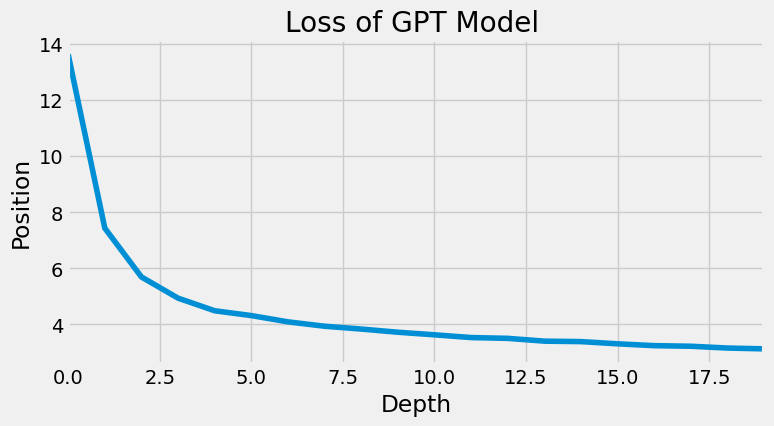

In [69]:
# Visualization - Graph
plt.style.use('fivethirtyeight')
plt.figure(figsize=[8, 4])
plt.plot(losses)
plt.xlabel('Depth')
plt.xlim((0, n_epoch - 1))
plt.ylabel('Position')
plt.title("Loss of GPT Model ")
plt.show()